# PCA Analysis on VIX term structure
We will extract a smaller number of factors that can capture the movement of the term structure. We propose to use three methods for this analysis including traditional PCA over entire window, rolloiing window traditional PCA and rolling window exponential weighted PCA.

### Load files

In [119]:
import numpy as np
import pandas as pd
from datetime import datetime
dfs = pd.read_excel("09.9.21_ux1-8.xlsx", sheet_name="data")
dfs.head()

,Date,UX1..index,UX2..index,UX3..index,UX4..index,UX5..index,UX6..index,UX7..index,UX8..index,VIX.Index,slope(UX8-UX1),curvature(8+2-2*5),curvature(1+8-2*5),slope(UX5-UX1)
0,2009-09-21,26.70,28.40,28.05,28.65,28.70,28.60,28.70,28.70,24.06,2.00,-0.30,-2.00,2.00
1,2009-09-22,26.10,28.05,27.80,28.55,28.75,28.60,28.90,28.50,23.08,2.40,-0.95,-2.90,2.65
2,2009-09-23,26.35,28.15,27.85,28.30,28.60,28.45,28.65,28.60,23.49,2.25,-0.45,-2.25,2.25
3,2009-09-24,26.90,28.50,28.35,28.80,29.15,29.10,29.35,28.65,24.95,1.75,-1.15,-2.75,2.25
4,2009-09-25,27.00,28.55,28.35,28.85,29.25,29.20,29.50,29.40,25.61,2.40,-0.55,-2.10,2.25


In [120]:
df_commodity = pd.read_csv("commodity.csv",index_col=0)
df_equtiy = pd.read_csv("equity.csv", index_col=0)
df_fixedIncome = pd.read_csv("fixed_income.csv",index_col=0)
df_fx = pd.read_csv("fx.csv",index_col=0)
df_commodity["Date"] = df_commodity["Date"].apply(lambda x: datetime.strptime(x , "%Y-%m-%d"))
df_equtiy["Date"] = df_equtiy["Date"].apply(lambda x: datetime.strptime(x , "%Y-%m-%d"))
df_fixedIncome["Date"] = df_fixedIncome["Date"].apply(lambda x: datetime.strptime(x , "%Y-%m-%d"))
df_fx["Date"] = df_fx["Date"].apply(lambda x: datetime.strptime(x , "%Y-%m-%d"))

df_commodity.name = 'commodity'
df_equtiy.name = 'equtiy'
df_fixedIncome.name = 'fixedIncome'
df_fx.name = 'fx'

## Fill Missing Data

Check if the dataframe contains NaN:

In [121]:
dfs.isna().sum().sum()

1

In [122]:
dfs.columns[dfs.isna().any()]

Index(['VIX.Index'], dtype='object')

One vix index is NaN, we will fill the missing value by forward filling, which is filled by the previous date's data.

In [123]:
dfs = dfs.fillna(method='ffill')
dfs.isna().sum().sum()

0

In [124]:
## fill missing data in pontential factor files as well
df_commodity = df_commodity.fillna(method='ffill')
df_equtiy = df_equtiy.fillna(method='ffill')
df_fixedIncome = df_fixedIncome.fillna(method='ffill')
df_fx = df_fx.fillna(method='ffill')

## Term Structure Snapshot

In [125]:
import matplotlib.pyplot as plt
listTermStructureColumn = ["VIX.Index",'UX1..index', 'UX2..index', 'UX3..index', 'UX4..index',
       'UX5..index', 'UX6..index', 'UX7..index', 'UX8..index']
def getTermStruturePlot(df, date):
    dfs[dfs['Date'] == date]
    plt.plot(np.array([n for n in range(9)]), np.array(dfs[dfs['Date'] == date][listTermStructureColumn]).flatten())

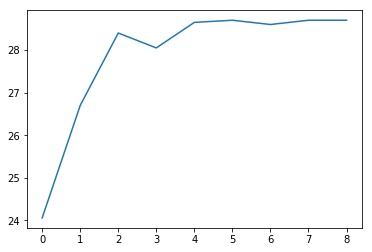

In [127]:
date = datetime(2009, 9, 21)
getTermStruturePlot(dfs, date)

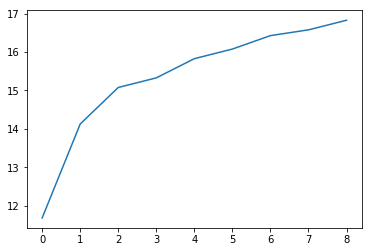

In [128]:
date = datetime(2018, 9, 21)
getTermStruturePlot(dfs, date)

Let's take a look on the data distribution of the term structure with only 3 futures prices

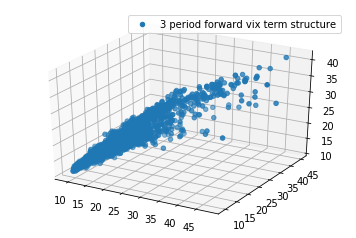

In [129]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x, y, z =  dfs[listTermStructureColumn[0]], dfs[listTermStructureColumn[1]], dfs[listTermStructureColumn[2]]
ax.scatter(x, y, z, label='3 period forward vix term structure')
ax.legend()
plt.show()

From the graph above, one can feel is that the term structure lies on a 2-d surface, which suggests us to consider the PCA analysis.

Load factors in each asset classes for future usage.

In [130]:
df_factor = pd.merge(df_commodity, df_equtiy, right_index=True, left_index=True, on="Date")
df_factor = pd.merge(df_factor, df_fixedIncome, right_index=True, left_index=True, on="Date")
df_factor = pd.merge(df_factor, df_fx, right_index=True, left_index=True, on="Date")
df_factor = df_factor.dropna()
df_factor.head()

,Date,CL1.Comdty_x,CL1.Comdty_y,XAU.Curncy,RTY.Index_x,RTY.Index_y,MXEA.Index,LEGATRUU.Index_x,LEGATRUU.Index_y,LF98TRUU.Index,LGTRTRUU.Index,LUACTRUU.Index,LUATTRUU.Index,USDJPY.Curncy_x,USDJPY.Curncy_y,USDEUR.Curncy
567,1992-03-31,19.44,19.44,341.70,208.22,208.22,792.25,210.56,210.56,528.24,98.51,1057.16,1046.10,131.85,131.85,0.8
568,1992-04-01,19.84,19.84,344.00,206.88,206.88,790.92,211.66,211.66,528.43,98.51,1059.18,1047.59,131.76,131.76,0.8
569,1992-04-02,19.80,19.80,340.60,206.42,206.42,787.80,211.95,211.95,527.52,98.51,1060.14,1047.79,131.92,131.92,0.8
570,1992-04-03,20.29,20.29,340.60,207.78,207.78,787.89,212.35,212.35,526.85,98.51,1056.33,1043.14,132.88,132.88,0.8
571,1992-04-06,20.45,20.45,339.25,206.39,206.39,776.58,212.09,212.09,525.72,98.51,1055.68,1041.96,133.45,133.45,0.8


## Traditional PCA
Here we are trying to get a smaller term in vix term structure which can explain the term structure.

Import backend PCA utility functions.

In [131]:
from PCA_UtilityFunc import rollingPCA, weightedPCA, dfPCA, logreturns, expweight, df_merge, clean_df
import math
from sklearn.decomposition import PCA

In [138]:
n = 4 #number of compoents for PCA
index = ['PC1', 'PC2', "PC3", "PC4"]
#index = ['PC1', 'PC2', "PC3"]
pca = PCA(n_components=n)
principalComponents = pca.fit(dfs.drop('Date', axis = 1)[listTermStructureColumn])
pca_result = pd.DataFrame(principalComponents.explained_variance_ratio_, index = index, columns=["eigenvalues"])
pca_result


,eigenvalues
PC1,0.931699
PC2,0.061547
PC3,0.004241
PC4,0.001512


In [139]:
principalComponents.explained_variance_ 

array([207.69413729,  13.72015774,   0.9454942 ,   0.33704877])

In [137]:
principalComponents.explained_variance_ 

array([207.69413729,  13.72015774,   0.9454942 ])

Eigenvectors (the directions which have most variance)

In [141]:
eigenVectors = pd.DataFrame(principalComponents.components_, index = ['PC1', 'PC2', "PC3", "PC4"])
eigenVectors

,0,1,2,3,4,5,6,7,8
PC1,0.360137,0.348097,0.344398,0.338348,0.331572,0.327557,0.321595,0.316613,0.308446
PC2,0.673057,0.426736,0.106978,-0.053495,-0.150681,-0.221291,-0.270992,-0.307499,-0.333044
PC3,0.540547,-0.266851,-0.474032,-0.344236,-0.206463,-0.034671,0.151528,0.300667,0.369059
PC4,-0.352229,0.738954,-0.107912,-0.308842,-0.285486,-0.154061,0.032035,0.176996,0.291997


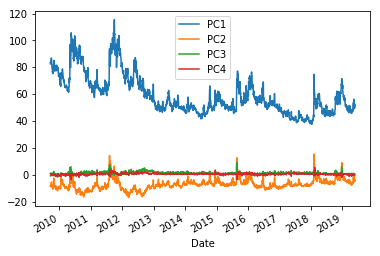

In [155]:
a = dfs.drop('Date', axis = 1)[listTermStructureColumn]
decomp_set = pd.DataFrame(np.dot(a, eigenVectors.T), columns=["PC1", "PC2", "PC3", "PC4"])
decomp_set.index =  dfs.Date
decomp_set.plot()

## Rolling Window Tranditional PCA

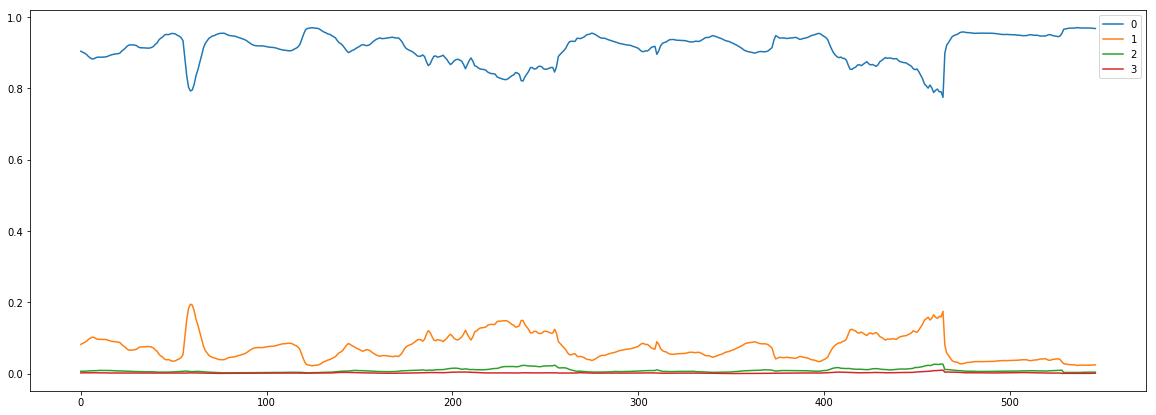

In [113]:
ws = 252
n = 4 #number of compoents for PCA
eigenvalues = [[] for i in range(n)]
eigenvectors = {}
newdf = dfs.drop('Date', axis = 1)[listTermStructureColumn]
i=0
while (i+ws) <= len(newdf):
    subdf = newdf.iloc[i:(i+ws),:]
    pca = PCA(n_components=n)
    principalComponents = pca.fit(subdf[listTermStructureColumn])
    results = principalComponents.explained_variance_ratio_
    eigenvectors[i] = principalComponents.components_
    for j in range(n):
        eigenvalues[j].append(float(results[j]))
        i+=1
    
f = pd.DataFrame(data = eigenvalues).T

f.plot(figsize=(20,7))

In [118]:
eigenvectors

{0: array([[ 0.42453813,  0.37995187,  0.34810097,  0.32553014,  0.31339356,
          0.30716445,  0.29479724,  0.29393885,  0.28703451],
        [ 0.7038272 ,  0.34724961,  0.0092832 , -0.14133185, -0.16332278,
         -0.21510097, -0.26207427, -0.31911637, -0.34716449],
        [ 0.54387742, -0.56206585, -0.4289782 , -0.21108354, -0.06884458,
          0.10076311,  0.20283401,  0.25291894,  0.19924448],
        [ 0.13407491, -0.54080338,  0.17711066,  0.51034643,  0.44272449,
          0.01472476, -0.23443935, -0.20797278, -0.32139956]]),
 4: array([[ 0.42207496,  0.37815098,  0.34719029,  0.32537706,  0.31424566,
          0.30805092,  0.29654563,  0.29562417,  0.28890236],
        [ 0.70321762,  0.34791397,  0.01618906, -0.13142844, -0.16300927,
         -0.21332936, -0.26619877, -0.32074837, -0.34796923],
        [ 0.54075664, -0.53581488, -0.43107603, -0.25131001, -0.07751139,
          0.10030277,  0.21513009,  0.26345526,  0.19935675],
        [ 0.15722071, -0.58344564,  0.19

## Rolling Window Exponential PCA

Text(0.5,1,"First 15th Components' Eigenvalue")

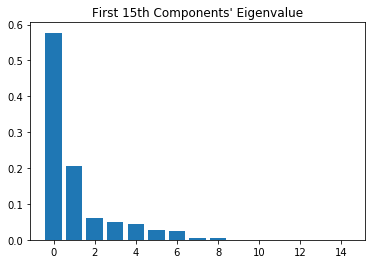

In [71]:
plt.bar([x for x in range(15)], dfPCA(logreturns(df_factor.drop('Date', axis = 1)), 15))
plt.title("First 15th Components' Eigenvalue")